In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# imports
from pathlib import Path
import sys  

# Get my_package directory path from Notebook
parent_dir = str(Path().resolve().parents[0])

# Add to sys.path
sys.path.insert(0, parent_dir)


In [4]:
from utils.experiment_utils import get_all_experiments_info, load_best_model

device = 'cuda'
configs = get_all_experiments_info('../outputs/', False)
cfgs = [
    c for c in configs if 'methyl_exp_b1810a5daebea296506a125ae64223f7' in c['name'] 
]   



In [5]:
! ls ../outputs/methyl_exp_b1810a5daebea296506a125ae64223f7

best_model.pt		checkpoint_epoch_2.pt  checkpoint_epoch_9.pt
checkpoint_epoch_10.pt	checkpoint_epoch_3.pt  config.yaml
checkpoint_epoch_11.pt	checkpoint_epoch_4.pt  text_samples_epoch_12
checkpoint_epoch_12.pt	checkpoint_epoch_5.pt  text_samples_epoch_2
checkpoint_epoch_13.pt	checkpoint_epoch_6.pt  text_samples_epoch_4
checkpoint_epoch_14.pt	checkpoint_epoch_7.pt  text_samples_epoch_6
checkpoint_epoch_1.pt	checkpoint_epoch_8.pt  text_samples_epoch_9


In [6]:
import torch
import hydra

def instantiate_and_load_model(config) -> torch.nn.Module:
    """
    Instantiate and load a model from a checkpoint file.
    
    Args:
        model_path: The path to the model checkpoint file
        device: The device to load the model on

    Returns:
        The loaded model
    """
    cfg = config['config']
    encoder = hydra.utils.instantiate(cfg.encoder)
    generator = hydra.utils.instantiate(cfg.generator)

    checkpoint = torch.load(config['dir'] + '/checkpoint_epoch_11.pt', map_location=device, weights_only=False)
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    generator.model.load_state_dict(checkpoint['generator_state_dict'])
    return encoder, generator

In [7]:
enc, gen = instantiate_and_load_model(cfgs[0])

In [8]:
dataset = hydra.utils.instantiate(cfgs[0]['config']['dataset'])

Loading tissues:   6%|▌         | 5/83 [03:53<1:00:37, 46.64s/it]


In [15]:
from mixer.mixer import SetMixer
mixer = SetMixer(k=3, alpha=0.5)

In [33]:
# create oh one hot encoding of dataset.tissue_types
tissue_types = dataset.tissue_types
tissue_types_oh = torch.eye(len(tissue_types))
tissue_types_oh = {tissue_type: tissue_types_oh[i] for i, tissue_type in enumerate(tissue_types)}


In [36]:
import numpy as np
test = []
for i in range(5):
    test.append(dataset[i])
    print(len(test), i)
    test[i]['tissue_type'] = tissue_types_oh[dataset.tissue_types[i]].repeat(test[i]['samples']['encoder_inputs'].shape[0], 1)


1 0
2 1
3 2
4 3
5 4


In [40]:
mixer.collate_fn(test)['tissue_type'].mean(dim=1)

tensor([[0.0000, 0.7000, 0.3000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.6500, 0.0000, 0.0000, 0.1000, 0.0000],
        [0.0000, 0.0000, 0.3500, 0.6500, 0.0000, 0.0000],
        [0.5500, 0.0000, 0.4500, 0.0000, 0.0000, 0.0000],
        [0.1000, 0.0000, 0.0000, 0.1500, 0.7500, 0.0000]])

tensor([1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)

In [16]:
from torch.utils.data import DataLoader
dl = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=mixer.collate_fn)
for batch in dl:
    print(batch['samples'])
    break


{'encoder_inputs': tensor([[[[0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [1., 0., 0., 0., 0.],
          ...,
          [0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 1.]],

         [[1., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0.],
          [0., 1., 0., 0., 0.],
          ...,
          [0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 1.]],

         [[1., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0.],
          [1., 0., 0., 0., 0.],
          ...,
          [0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 1.]],

         ...,

         [[0., 1., 0., 0., 0.],
          [1., 0., 0., 0., 0.],
          [0., 0., 0., 1., 0.],
          ...,
          [0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 1.]],

         [[0., 0., 1., 0., 0.],
          [0., 0., 1., 0., 0.],
          [1., 0., 0., 0., 0.],
          ...,
          [0., 0., 

In [17]:
batch['tissue_type']

['Heart-Cardiomyocyte',
 'Pancreas-Alpha',
 'Aorta-Endothel',
 'Blood-Granulocytes',
 'Lung-Alveolar-Endothel',
 'Lung-Alveolar-Endothel',
 'Lung-Alveolar-Endothel',
 'Aorta-Endothel',
 'Lung-Alveolar-Endothel',
 'Aorta-Endothel',
 'Heart-Cardiomyocyte',
 'Blood-Granulocytes',
 'Aorta-Endothel',
 'Aorta-Endothel',
 'Blood-Granulocytes',
 'Blood-Granulocytes']

In [14]:
batch['tissue_type']

['Aorta-Endothel',
 'Heart-Cardiomyocyte',
 'Lung-Alveolar-Endothel',
 'Pancreas-Alpha',
 'Tongue-Epithelial',
 'Tongue-Epithelial',
 'Tongue-Epithelial',
 'Lung-Alveolar-Endothel',
 'Aorta-Endothel',
 'Blood-Granulocytes',
 'Lung-Alveolar-Endothel',
 'Aorta-Endothel',
 'Lung-Alveolar-Endothel',
 'Blood-Granulocytes',
 'Heart-Cardiomyocyte',
 'Lung-Alveolar-Endothel']

In [10]:
enc.to('cuda')
enc.eval()


DNAConvEncoder(
  (initial_conv): Sequential(
    (0): Conv1d(5, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
  )
  (gnn_layers): ModuleList(
    (0-2): 3 x Conv1DGNNLayer(
      (conv): Sequential(
        (0): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
      (update): Sequential(
        (0): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
      )
    )
  )
  (final_conv): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (pre_pool_mlp): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=256, out

In [11]:
sample_lats = {}
sample_tissues = {}

In [9]:
import gc
try:
    del tissue_data, lat
except:
    pass
gc.collect()
torch.cuda.empty_cache()

In [12]:
import numpy as np
import gc

num_samples = 5

for sample in dataset.sample_to_indices.keys():
    print(sample)

    # try:
    #     del tissue_data, lat
    # except:
    #     pass
    # gc.collect()
    # torch.cuda.empty_cache()
    sample_lats[sample] = np.zeros((num_samples, 64))
    np_sample_to_indices = np.array(dataset.sample_to_indices[sample])
    for i in range(num_samples):
        # sample 8192 random indices
        indices = np.random.choice(len(dataset.sample_to_indices[sample]), 8192, replace=False)
        with torch.no_grad():
            tissue_data = torch.cat([
                dataset.data[idx]['tokenized']['encoder_inputs'] 
                for idx in np_sample_to_indices[indices]
            ]).unsqueeze(0).to(device)
            lat = enc(tissue_data)
            sample_lats[sample][i] = lat.cpu().detach().numpy()
        sample_tissues[sample] = dataset.data[dataset.sample_to_indices[sample][0]]['tissue_type']

GSM5652192
GSM5652191
GSM5652193
GSM5652179
GSM5652180
GSM5652214
GSM5652212
GSM5652217
GSM5652213
GSM5652215
GSM5652314
GSM5652315
GSM5652313
GSM5652329
GSM5652328
GSM5652327
GSM5652255
GSM5652254
GSM5652253
GSM5652247
GSM5652248
GSM5652249
GSM5652321
GSM5652231
GSM5652207
GSM5652364
GSM5652363
GSM5652362
GSM5652262
GSM5652263
GSM5652261
GSM5652182
GSM5652183
GSM5652181
GSM5652351
GSM5652350
GSM5652353
GSM5652281
GSM5652279
GSM5652280
GSM5652355
GSM5652356
GSM5652354
GSM5652334
GSM5652285
GSM5652286
GSM5652287
GSM5652197
GSM5652322
GSM5652323
GSM5652324
GSM5652310
GSM5652311
GSM5652312
GSM5652330
GSM5652206
GSM5652205
GSM5652333
GSM5652332
GSM5652297
GSM5652298
GSM5652266
GSM5652264
GSM5652265
GSM5652190
GSM5652267
GSM5652268
GSM5652269
GSM5652260
GSM5652259
GSM5652258
GSM5652188
GSM5652187
GSM5652189
GSM5652251
GSM5652252
GSM5652250
GSM5652275
GSM5652274
GSM5652276
GSM5652289
GSM5652290
GSM5652288
GSM5652284
GSM5652282
GSM5652283
GSM5652209
GSM5652341
GSM5652340
GSM5652339
GSM5652270

In [13]:
np.stack(list(sample_lats.values())).squeeze().shape


(228, 5, 64)

/tmp/ipykernel_807781/3693888843.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('nipy_spectral', n_labels)


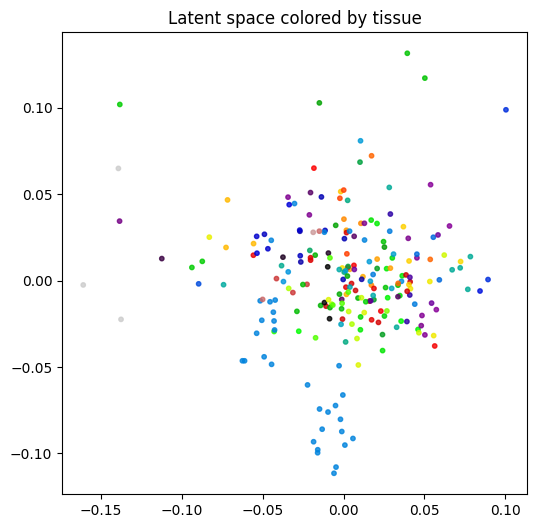

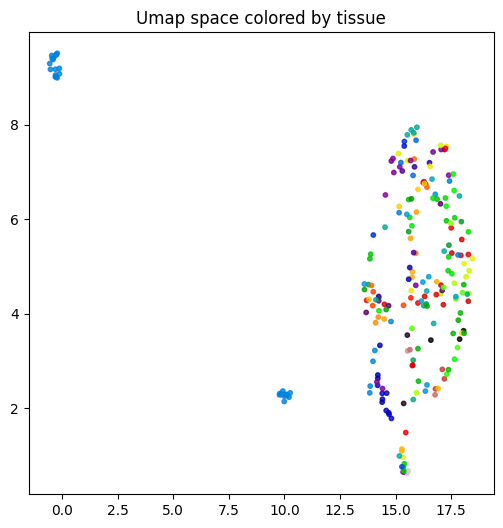

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from umap import UMAP

# Assume sample_lats and sample_tissues are defined
stacked_lats = np.stack(list(sample_lats.values())).mean(axis=1)

stacked_tissues = np.array(list(sample_tissues.values()))

# PCA
pca = PCA(n_components=2)
pca_lats = pca.fit_transform(stacked_lats)

# UMAP
umap = UMAP(n_components=2)
umap_lats = umap.fit_transform(stacked_lats)

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.preprocessing import LabelEncoder
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Label encode tissues
le = LabelEncoder()
color_labels = le.fit_transform(stacked_tissues)
unique_labels = le.classes_
n_labels = len(unique_labels)

# Generate N distinct colors from a continuous colormap
cmap = cm.get_cmap('nipy_spectral', n_labels)
colors = [cmap(i) for i in range(n_labels)]

# Create a mapping for plotting
label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}

# Now plot your scatter
plt.figure(figsize=(6, 6))
plt.scatter(pca_lats[:, 0], pca_lats[:, 1], 
            c=[label_to_color[label] for label in stacked_tissues], 
            s=10, alpha=0.8)
plt.title("Latent space colored by tissue")
plt.show()

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(umap_lats[:, 0], umap_lats[:, 1], 
            c=[label_to_color[label] for label in stacked_tissues], 
            s=10, alpha=0.8)
plt.title("Umap space colored by tissue")
plt.show()


/tmp/ipykernel_807781/737892918.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('nipy_spectral', n_labels)


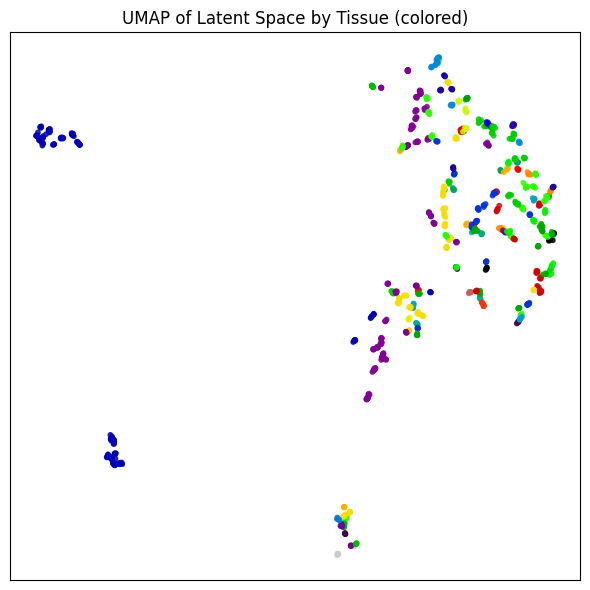

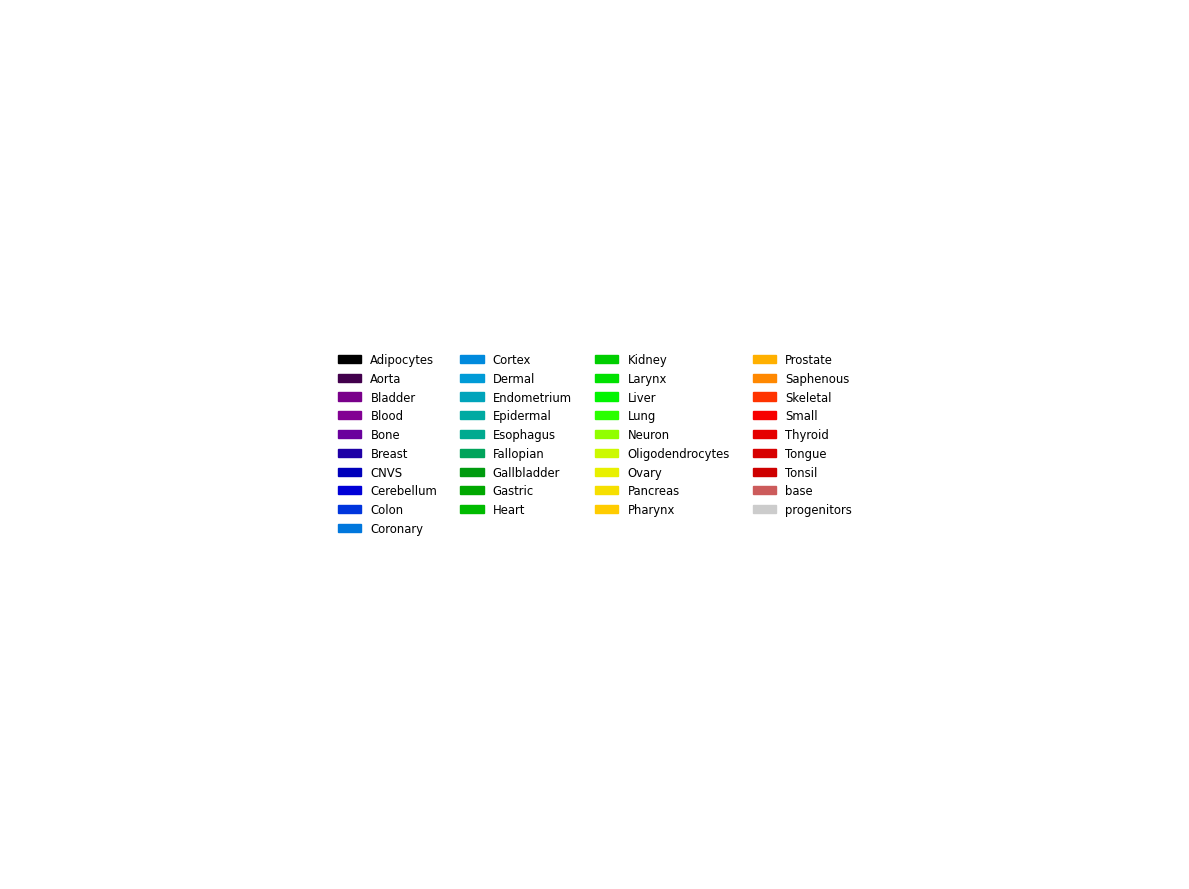

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import matplotlib.cm as cm

# Assume sample_lats and sample_tissues are defined dictionaries
stacked_lats = np.stack(list(sample_lats.values())).mean(axis=1)
stacked_tissues = np.array([tissue.split('-')[0] for tissue in sample_tissues.values()])

# Assume sample_lats and sample_tissues are defined dictionaries
stacked_lats = np.stack(list(sample_lats.values())).reshape(-1, 64)
stacked_tissues = np.array([tissue.split('-')[0] for tissue in sample_tissues.values() for _ in range(num_samples)])

# Label encode
le = LabelEncoder()
color_labels = le.fit_transform(stacked_tissues)
unique_labels = le.classes_
n_labels = len(unique_labels)

# Generate distinct colors using a continuous colormap
cmap = cm.get_cmap('nipy_spectral', n_labels)
colors = [cmap(i) for i in range(n_labels)]
label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}

# UMAP
umap = UMAP(n_components=2, n_neighbors=35, min_dist=0.1)
umap_lats = umap.fit_transform(stacked_lats)

# PCA Scatter Plot (colored by label)
plt.figure(figsize=(6, 6))
plt.scatter(umap_lats[:, 0], umap_lats[:, 1],
            c=[label_to_color[label] for label in stacked_tissues],
            s=10, alpha=0.8)
plt.title("UMAP of Latent Space by Tissue (colored)")
plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.savefig("latent_space_pca.png", dpi=30)
plt.show()

# Separate Legend Image
legend_handles = [Patch(color=label_to_color[label], label=label) for label in unique_labels]
n_cols = 4  # Adjust based on space
fig, ax = plt.subplots(figsize=(12, max(2, len(legend_handles) // n_cols)))
ax.axis('off')
ax.legend(handles=legend_handles, loc='center', ncol=n_cols, frameon=False, fontsize='small')
plt.tight_layout()
plt.savefig("tissue_legend.png", dpi=300)
plt.show()



In [16]:
import pickle

with open('sample_lats.pkl', 'wb') as f:
    pickle.dump(sample_lats, f)

with open('sample_tissues.pkl', 'wb') as f:
    pickle.dump(sample_tissues, f)